In [34]:
(* parameters *)
(* 最大次数 *)
maxOrderNum = 200;
(* 画像URL, もしくはローカルパス *)
imageURL = "https://www.google.com/images/branding/googlelogo/2x/googlelogo_color_160x56dp.png";
 
(*
  エッジ点からランダムカーブを取得
*)
pointListToLines[pointList_, neighbothoodSize_: 6] := Module[
  {
    (* 重複を削除したものをLへ代入 *)
    L = DeleteDuplicates[pointList],
    NF,
    lambda,
    lineBag,
    counter,
    seenQ,
    sLB,
    nearest,
    nearest1,
    nextPoint,
    couldReverseQ,
    d, n, s
  },
  (* Lに対するnearist関数を定義 *)
  NF = Nearest[L];
  (* 重複無しの長さを取得 *)
  lambda = Length[L];
  Monitor[
    (* データをここに格納 *)
    lineBag = {};
    counter = 0;
    While[counter < lambda,
      (* 未選択のランダムな一点を選択 *)
      sLB = {RandomChoice[DeleteCases[L, _?seenQ]]};
      (* 選択された部分はフラグを立てる *)
      seenQ[sLB[[1]]] = True;
      counter++;
      couldReverseQ = True;
      (* データの生成 *)
      While[
        (
          (* neighbothoodSizeを中心とする点群の集合を作成 *)
          nearest = NF[Last[sLB], {Infinity, neighbothoodSize}];
          (* ユークリッド距離でソート *)
          nearest1 = SortBy[DeleteCases[nearest, _?seenQ], 1. EuclideanDistance[Last[sLB], #] &];
          nearest1 =!= {} || couldReverseQ
        ),
        If[nearest1 === {},
          (* 全ての点を網羅したとき終了 *)
          sLB = Reverse[sLB];
          couldReverseQ = False,
          (* まだ残っているのであれば、次点を作成 *)
          nextPoint = If[Length[sLB] <= 3,
              (* sLBの中身が3以下であれば、一番中心と近い点を抽出 *)
              nearest1[[1]],
              (* 3つ以上あるならば、急カーブとならないよう抽出点を調整 *)
              d = 1. Normalize[(sLB[[-1]] - sLB[[-2]]) + 1/2 (sLB[[-2]] - sLB[[-3]])];
              n = {-1, 1} Reverse[d];
              s = Sort[{Sqrt[(d.(# - sLB[[-1]]))^2 + 2 (n. (# - sLB[[-1]]))^2], #} & /@ nearest1];
              s[[1, 2]]
          ];
          AppendTo[sLB, nextPoint];
          seenQ[nextPoint] = True;
          counter++
        ]
      ];
      AppendTo[lineBag, sLB]
    ];
    (* 線の長さでソートしたものを返す *)
    Reverse[SortBy[Select[lineBag, Length[#] > 12 &], Length]],
  ]
]

(* 1ラインのユークリッド弧長を表示 *)
fourierComponentData[pointList_, nMax_, op_] := Module[
  {
    epsilon = 10^-3, myu = 2^14, M = 10000, s, scale, delta, L, 
    nds, sMax, if, xyFunction, X, Y, XFT, YFT, type
  },
  (* prepare curve *)
  scale = 1. Mean[Table[
      Max[fl /@ pointList] - Min[fl /@ pointList], {fl, {First, Last}}
    ]
  ];
  delta = EuclideanDistance[First[pointList], Last[pointList]];
  L = Which[
    op === "Closed",
    type = "Closed";
    If[First[pointList] === Last[pointList], pointList,
     Append[pointList, First[pointList]]],
    
    op === "Open",
    type = "Open";
    pointList,
    
    delta == 0.,
    type = "Closed";
    pointList,
    
    delta/scale < op,
    type = "Closed";
    Append[pointList, First[pointList]],
    
    True,
    type = "Open";
    Join[pointList, Rest[Reverse[pointList]]]];

  (* B-スプライン曲線 *)
  xyFunction = BSplineFunction[L, SplineDegree -> 4];
  nds = NDSolve[{s'[t] == Sqrt[xyFunction'[t].xyFunction'[t]], s[0] == 0}, s, {t, 0, 1}, MaxSteps -> 10^5, PrecisionGoal -> 4];
  (* total curve length *)
  sMax = s[1] /. nds[[1]];
  if = Interpolation[Table[{s[rho] /. nds[[1]], rho}, {rho, 0, 1, 1/M}]];
  X[t_Real] := BSplineFunction[L][Max[Min[1, if[(t + Pi)/(2 Pi) sMax]], 0]][[1]];
  Y[t_Real] := BSplineFunction[L][Max[Min[1, if[(t + Pi)/(2 Pi) sMax]], 0]][[2]];
  (* extract Fourier coefficients *)
  {XFT, YFT} = 
   Fourier[Table[#[N@t], {t, -Pi + epsilon, 
        Pi - epsilon, (2 Pi - 2 epsilon)/myu}]] & /@ {X, Y};
  {type, 2 Pi/
     Sqrt[myu]*((Transpose[
         Table[{Re[#], Im[#]} &[Exp[I k Pi] #[[k + 1]]], {k, 0, 
           nMax}]] & /@ {XFT, YFT}))}]

fourierComponents[pointLists_, OptionsPattern[]] :=
 Monitor[
   Table[fourierComponentData[
     pointLists[[k]],
     If[Head[#] === List, #[[k]], #] &[OptionValue["MaxOrder"]],
     If[Head[#] === List, #[[k]], #] &[OptionValue["OpenClose"]]
     ], {k, Length[pointLists]}],
   Grid[
    {{Text[
       Style[
        "progress calculating Fourier coefficients",
        Darker[Green, 0.66]]],
      ProgressIndicator[k/Length[pointLists]]}},
    Alignment -> Left, Dividers -> Center]] /; Depth[pointLists] === 4
 
makeFourierSeries[
  {"Closed" | "Open", {{cax_, sax_}, {cay_, say_}}},
  t_, n_] :=
 {Sum[If[k == 0, 1/2, 1] cax[[k + 1]] Cos[k t] + 
    sax[[k + 1]] Sin[k t], {k, 0, Min[n, Length[cax]]}],
  Sum[If[k == 0, 1/2, 1] cay[[k + 1]] Cos[k t] + 
    say[[k + 1]] Sin[k t], {k, 0, Min[n, Length[cay]]}]}
 
paraplot[n_] :=
 Show[
  {ParametricPlot[
    Evaluate[makeFourierSeries[#, t, n] & /@ fCs],
    {t, -Pi, Pi}, Axes -> False](*,
   Graphics[Text[Style["n="<>ToString[n],Large,Bold],
   Scaled[{.9,.1}] ]]*)}(*,ImageSize->{500,500}*)]
   

In [51]:
imgData = "../data/resize_image.jpg"

../data/resize_image.jpg


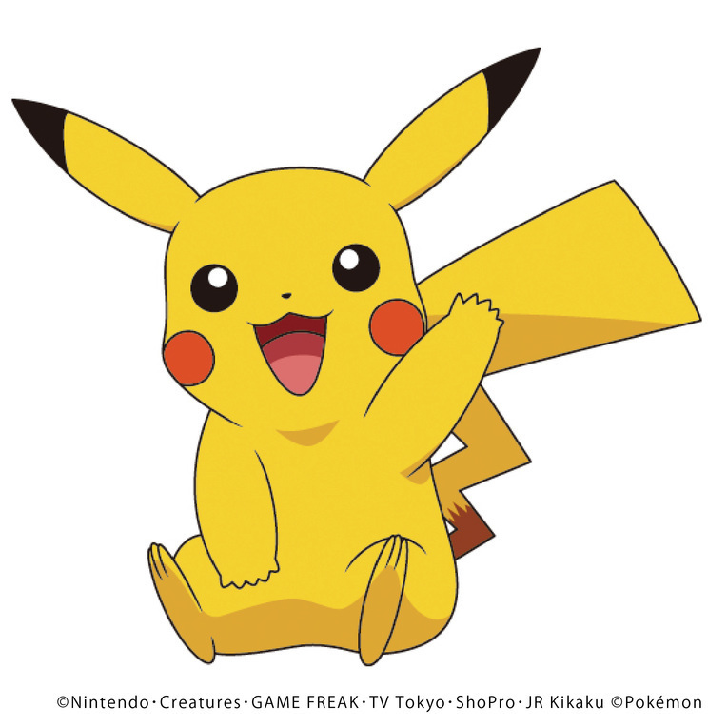

In [52]:
img = Import[imgData]

FrontEndObject::notavail: 
 A front end is not available; certain operations require a front end.
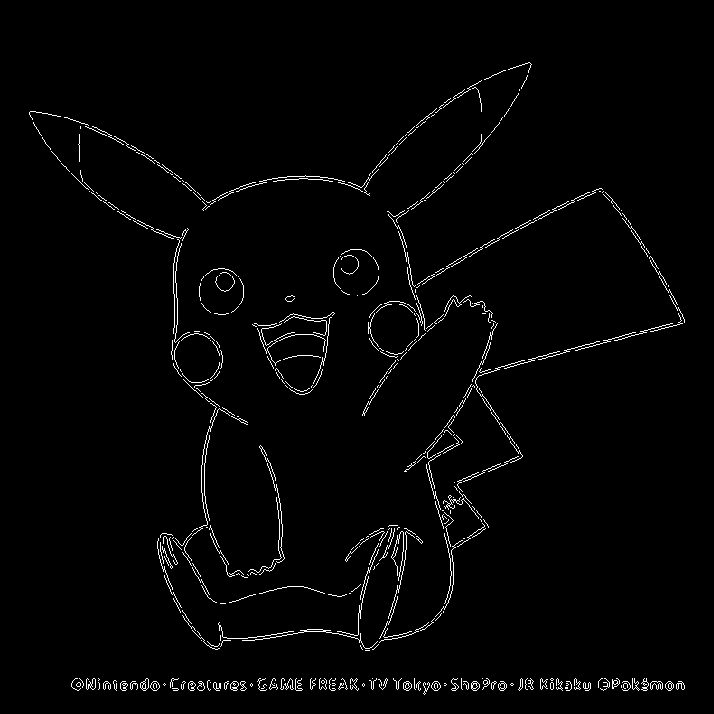

In [53]:
edgeImage = Thinning[EdgeDetect[ColorConvert[
    ImagePad[Image[Map[Most, ImageData[img], {2}]], 20, White], 
    "Grayscale"]]]
data = ImageData[edgeImage];
pos = Position[data, 1, {2}];
edgePoints = Apply[{#2, -#1} &, pos, {1}];
SeedRandom[2];
hLines = pointListToLines[edgePoints, 16];
Graphics[{ColorData["DarkRainbow"][RandomReal[]], Line[#]} & /@ hLines];

FrontEndObject::notavail: 
 A front end is not available; certain operations require a front end.
 
 
 Out[61]:
 
 
 
 
 Out[64]:
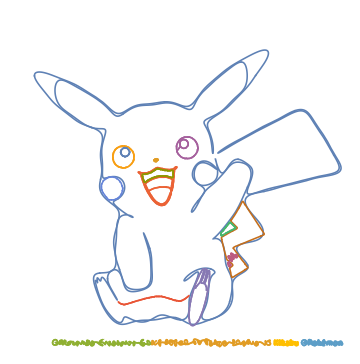
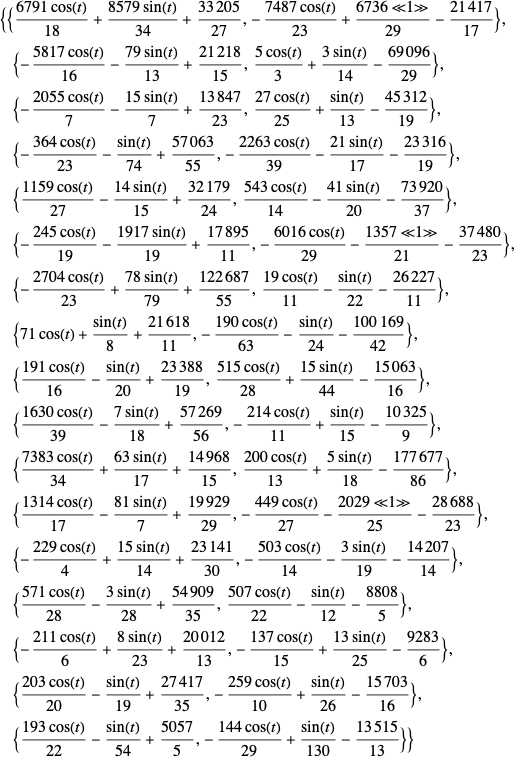

In [60]:
fCs = fourierComponents[hLines];
Show[ParametricPlot[
   Evaluate[makeFourierSeries[#, t, 100] & /@ fCs],
   {t, -Pi, Pi}, Axes -> False]]
    
curves = makeFourierSeries[#, t, 1] & /@ fCs;
Style[Map[Short, Rationalize[curves, 0.002]], 16] // TraditionalForm


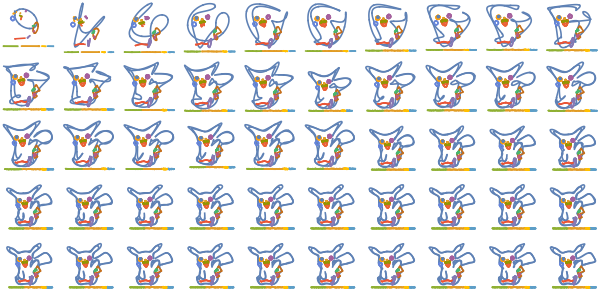

In [56]:
Partition[Table[paraplot[n], {n, 1, 50}], 10] // GraphicsGrid

In [79]:
Dynamic[n]
Export["plot.gif", 
 Table[(n = x; paraplot[x]), {x, 1, maxOrderNum, 1}]]

Out[79]:
 
 
 
 
 Out[80]: